In [1]:
import pandas as pd
import numpy as np
import os
import sys

from equiboots.metrics import calculate_bootstrap_stats

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /home/lshpaner/Documents/GitHub_Repositories/equi_boots/py_scripts


In [2]:
import equiboots as eqb

from equiboots.tables import metrics_table

In [3]:
def generate_biased_synthetic_data(
    n_samples=1000, bias_strength="moderate", random_seed=42
):
    """
    Generate synthetic data with intentional bias to create statistically significant differences.

    Parameters:
    - n_samples: Number of samples to generate
    - bias_strength: 'mild', 'moderate', or 'strong' - controls the level of bias
    - random_seed: For reproducibility
    """
    np.random.seed(random_seed)

    # Define bias parameters based on strength
    bias_params = {
        "mild": {"race_bias": 0.15, "sex_bias": 0.08, "noise_level": 0.3},
        "moderate": {"race_bias": 0.25, "sex_bias": 0.15, "noise_level": 0.2},
        "strong": {"race_bias": 0.4, "sex_bias": 0.25, "noise_level": 0.1},
    }

    params = bias_params[bias_strength]

    # Generate demographic variables
    race = np.random.choice(
        ["white", "black", "asian", "hispanic"], n_samples, p=[0.4, 0.3, 0.15, 0.15]
    ).reshape(-1, 1)
    sex = np.random.choice(["M", "F"], n_samples, p=[0.5, 0.5]).reshape(-1, 1)

    # Create bias mappings
    race_bias_map = {
        "white": 0.0,  # baseline
        "black": -params["race_bias"],  # disadvantaged
        "asian": params["race_bias"] * 0.5,  # slight advantage
        "hispanic": -params["race_bias"] * 0.7,  # disadvantaged
    }

    sex_bias_map = {
        "M": params["sex_bias"] * 0.5,  # slight advantage
        "F": -params["sex_bias"] * 0.5,  # slight disadvantage
    }

    # Generate base probabilities with bias
    base_prob = 0.5  # neutral starting point

    # Apply demographic biases
    race_adjustments = np.array([race_bias_map[r[0]] for r in race])
    sex_adjustments = np.array([sex_bias_map[s[0]] for s in sex])

    # Combine biases with some noise
    noise = np.random.normal(0, params["noise_level"], n_samples)

    # Calculate biased probabilities
    y_prob = base_prob + race_adjustments + sex_adjustments + noise

    # Clip to valid probability range
    y_prob = np.clip(y_prob, 0.01, 0.99)

    # Generate predictions and true labels based on biased probabilities
    y_pred = (y_prob > 0.5).astype(int)

    # Make true labels correlated with the biased probabilities to simulate real bias
    # Add some randomness to make it realistic
    true_label_prob = y_prob * 0.8 + np.random.uniform(0, 0.4, n_samples)
    true_label_prob = np.clip(true_label_prob, 0.01, 0.99)
    y_true = np.random.binomial(1, true_label_prob)

    return y_true, y_prob, y_pred, race, sex

In [4]:
y_true, y_prob, y_pred, race, sex = generate_biased_synthetic_data(
    n_samples=1000,
    bias_strength="moderate",  # Try 'mild', 'moderate', or 'strong'
    random_seed=42,
)

# Create fairness DataFrame
fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)


# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])

Groups created


In [5]:
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,

In [6]:
fairness_df

race sex
0       white   M
1    hispanic   F
2       asian   F
3       black   F
4       white   F
..        ...  ..
995     white   F
996  hispanic   F
997     white   M
998  hispanic   M
999     black   M

[1000 rows x 2 columns]

In [7]:
sliced_race_data = eq.slicer("race")
race_metrics = eq.get_metrics(sliced_race_data)

sliced_sex_data = eq.slicer("sex")
sex_metrics = eq.get_metrics(sliced_sex_data)

In [8]:
test_config = {
    "test_type": "chi_square",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
}
stat_test_results_race = eq.analyze_statistical_significance(
    race_metrics, "race", test_config
)

stat_test_results_sex = eq.analyze_statistical_significance(
    sex_metrics, "sex", test_config
)

In [9]:
stat_test_results_race

{'omnibus': StatTestResult(statistic=224.80723962712176, p_value=8.156186456460242e-43, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.2737439433893907, confidence_interval=None),
 'hispanic': StatTestResult(statistic=58.54116074806115, p_value=4.818550670829595e-12, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.3193557341381798, confidence_interval=None),
 'asian': StatTestResult(statistic=25.16860583529919, p_value=5.6946124360756766e-05, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.21276107887062612, confidence_interval=None),
 'black': StatTestResult(statistic=111.22279329502825, p_value=2.394570546387375e-23, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.3952363702086561, confidence_interval=None)}

In [10]:
stat_test_results_sex

{'omnibus': StatTestResult(statistic=63.913721542946405, p_value=1.7128569617157582e-13, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.252811632530915, confidence_interval=None),
 'M': StatTestResult(statistic=63.913721542946405, p_value=1.7128569617157582e-13, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.252811632530915, confidence_interval=None)}

In [11]:
overall_stat_results = {"sex": stat_test_results_sex, "race": stat_test_results_race}

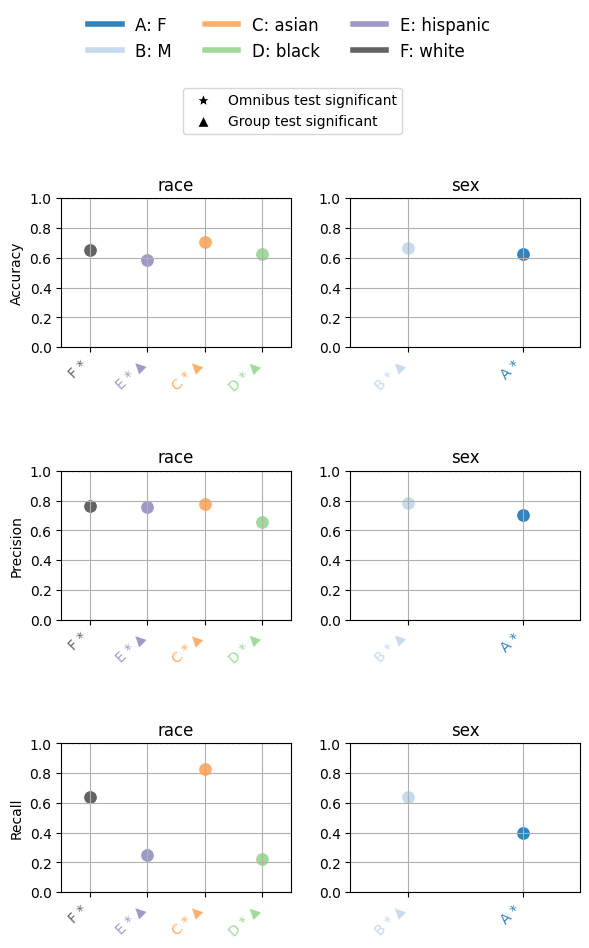

In [12]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[race_metrics, sex_metrics],
    metric_cols=[
        "Accuracy",
        "Precision",
        "Recall",
    ],
    category_names=["race", "sex"],
    figsize=(6, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    raw_metrics=True,
    show_grid=True,
    y_lim=(0, 1),
    statistical_tests=overall_stat_results,
)

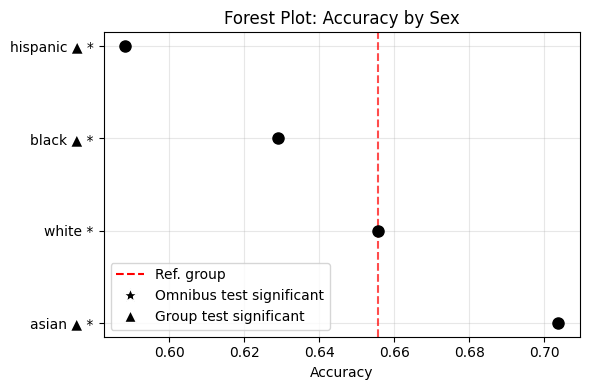

In [13]:
eqb.eq_plot_metrics_forest(
    group_metrics=race_metrics,
    metric_name="Accuracy",
    reference_group="white",
    title="Forest Plot: Accuracy by Sex",
    statistical_tests=stat_test_results_race,
)

In [14]:
stat_metrics_table_point = metrics_table(
    race_metrics, statistical_tests=stat_test_results_race, reference_group="white"
)

In [15]:
stat_metrics_table_point

white *  hispanic * ▲  asian * ▲   black * ▲
Accuracy                0.655582      0.588235   0.703704    0.628866
Precision               0.762557      0.760000   0.776699    0.658537
Recall                  0.642308      0.250000   0.824742    0.223140
F1 Score                0.697286      0.376238   0.800000    0.333333
Specificity             0.677019      0.922078   0.394737    0.917647
TP Rate                 0.642308      0.250000   0.824742    0.223140
FP Rate                 0.322981      0.077922   0.605263    0.082353
FN Rate                 0.357692      0.750000   0.175258    0.776860
TN Rate                 0.677019      0.922078   0.394737    0.917647
TP                    167.000000     19.000000  80.000000   27.000000
FP                     52.000000      6.000000  23.000000   14.000000
FN                     93.000000     57.000000  17.000000   94.000000
TN                    109.000000     71.000000  15.000000  156.000000
Predicted Prevalence    0.520190      0.163399   0.762963    0.140893

In [16]:
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()
eq2 = eqb.EquiBoots(
    y_true,
    y_pred,
    fairness_df,
    ["race", "sex"],
    y_prob,
    seeds=int_list,
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=1000,
    boot_sample_size=1000,
    balanced=True,  # False is stratified, True is balanced
    # stratify_by_outcome=True,
)

# Set seeds
eq2.set_fix_seeds(int_list)
print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])

boots_race_data = eq2.slicer("race")
race_metrics = eq2.get_metrics(boots_race_data)
dispa = eq2.calculate_disparities(race_metrics, "race")

seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 1000/1000 [00:01<00:00, 627.00it/s]


Groups created
Calculating metrics for each bootstrap:


100%|██████████| 1000/1000 [00:12<00:00, 81.27it/s]


In [17]:
diffs = eq2.calculate_differences(race_metrics, "race")

In [18]:
metrics_boot = ["Accuracy_diff", "Precision_diff", "Recall_diff"]


test_config = {
    "test_type": "bootstrap_test",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
    "tail_type": "two_tailed",
    "metrics": metrics_boot,
}

stat_test_results = eq.analyze_statistical_significance(
    race_metrics, "race", test_config, diffs
)

/home/lshpaner/Documents/GitHub_Repositories/equi_boots/src/equiboots/StatisticalTester.py:79: UserWarning: Warning: Calculation may not be correct, please increase number of bootstraps
  warnings.warn(


In [19]:
stat_test_results

{'hispanic': {'Accuracy_diff': StatTestResult(statistic=-0.06160000000000002, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.15337655620367746, 0.03017655620367741)),
  'Precision_diff': StatTestResult(statistic=0.006086344823399714, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.1328678614258402, 0.1450405510726396)),
  'Recall_diff': StatTestResult(statistic=-0.3978213477483664, p_value=0.0, is_significant=True, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.4821124547420439, -0.31353024075468894))},
 'asian': {'Accuracy_diff': StatTestResult(statistic=0.030399999999999986, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.05913925517414949, 0.11993925517414945)),
  'Precision_diff': StatTestResult(statistic=0.

In [20]:
race_metrics

[{'white': {'Accuracy': 0.684,
   'Precision': 0.7481481481481481,
   'Recall': 0.6917808219178082,
   'F1 Score': 0.7188612099644128,
   'Specificity': 0.6730769230769231,
   'TP Rate': 0.6917808219178082,
   'FP Rate': 0.3269230769230769,
   'FN Rate': 0.3082191780821918,
   'TN Rate': 0.6730769230769231,
   'TP': 101,
   'FP': 34,
   'FN': 45,
   'TN': 70,
   'Prevalence': 0.584,
   'Predicted Prevalence': 0.54,
   'ROC AUC': 0.6988277133825079,
   'Average Precision Score': 0.755149235382231,
   'Log Loss': 0.6260020100249253,
   'Brier Score': 0.21949169989981884,
   'Calibration AUC': 0.10116917461487344},
  'hispanic': {'Accuracy': 0.62,
   'Precision': 0.84,
   'Recall': 0.32558139534883723,
   'F1 Score': 0.4692737430167598,
   'Specificity': 0.9338842975206612,
   'TP Rate': 0.32558139534883723,
   'FP Rate': 0.06611570247933884,
   'FN Rate': 0.6744186046511628,
   'TN Rate': 0.9338842975206612,
   'TP': 42,
   'FP': 8,
   'FN': 87,
   'TN': 113,
   'Prevalence': 0.516,
   '

In [21]:
diffs

[{'hispanic': {'Accuracy_diff': -0.06400000000000006,
   'Precision_diff': 0.09185185185185185,
   'Recall_diff': -0.366199426568971,
   'F1_Score_diff': -0.24958746694765305,
   'Specificity_diff': 0.260807374443738,
   'TP_Rate_diff': -0.366199426568971,
   'FP_Rate_diff': -0.2608073744437381,
   'FN_Rate_diff': 0.366199426568971,
   'TN_Rate_diff': 0.260807374443738,
   'Prevalence_diff': -0.06799999999999995,
   'Predicted_Prevalence_diff': -0.34,
   'ROC_AUC_diff': -0.006150411825713742,
   'Average_Precision_Score_diff': -0.03341062470447753,
   'Log_Loss_diff': 0.16664338830601544,
   'Brier_Score_diff': 0.0366926859175237,
   'Calibration_AUC_diff': 0.05838224700361032},
  'asian': {'Accuracy_diff': 0.03199999999999992,
   'Precision_diff': 0.03685185185185191,
   'Recall_diff': 0.15686782673084043,
   'F1_Score_diff': 0.0967232056200028,
   'Specificity_diff': -0.33461538461538465,
   'TP_Rate_diff': 0.15686782673084043,
   'FP_Rate_diff': 0.3346153846153846,
   'FN_Rate_diff'

In [22]:
stat_test_results

{'hispanic': {'Accuracy_diff': StatTestResult(statistic=-0.06160000000000002, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.15337655620367746, 0.03017655620367741)),
  'Precision_diff': StatTestResult(statistic=0.006086344823399714, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.1328678614258402, 0.1450405510726396)),
  'Recall_diff': StatTestResult(statistic=-0.3978213477483664, p_value=0.0, is_significant=True, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.4821124547420439, -0.31353024075468894))},
 'asian': {'Accuracy_diff': StatTestResult(statistic=0.030399999999999986, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.05913925517414949, 0.11993925517414945)),
  'Precision_diff': StatTestResult(statistic=0.

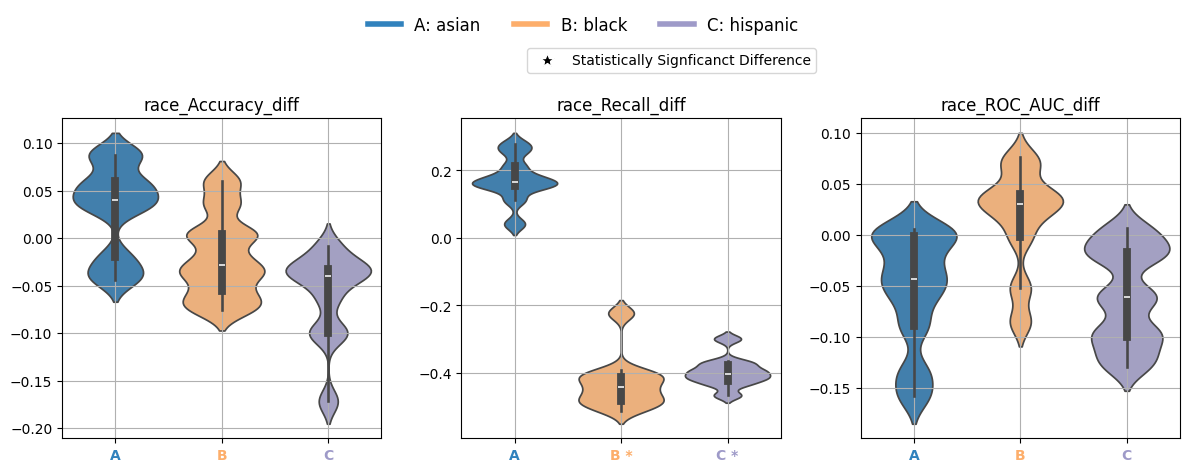

In [23]:
eqb.eq_group_metrics_plot(
    group_metrics=diffs,
    metric_cols=["Accuracy_diff", "Recall_diff", "ROC_AUC_diff"],
    name="race",
    categories="all",
    figsize=(12, 4),
    plot_type="violinplot",
    color_by_group=True,
    show_grid=True,
    strict_layout=True,
    save_path="./images",
    show_pass_fail=False,
    statistical_tests=stat_test_results,
)

In [24]:
stat_metrics_table_diff = metrics_table(
    race_metrics,
    statistical_tests=stat_test_results,
    differences=diffs,
    reference_group="white",
)

In [25]:
stat_test_results

{'hispanic': {'Accuracy_diff': StatTestResult(statistic=-0.06160000000000002, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.15337655620367746, 0.03017655620367741)),
  'Precision_diff': StatTestResult(statistic=0.006086344823399714, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.1328678614258402, 0.1450405510726396)),
  'Recall_diff': StatTestResult(statistic=-0.3978213477483664, p_value=0.0, is_significant=True, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.4821124547420439, -0.31353024075468894))},
 'asian': {'Accuracy_diff': StatTestResult(statistic=0.030399999999999986, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.05913925517414949, 0.11993925517414945)),
  'Precision_diff': StatTestResult(statistic=0.

In [26]:
eqb.calculate_bootstrap_stats(group_boot_metrics=race_metrics, metric="Accuracy")

group    mean  ci_lower  ci_upper       std  n_samples
0     white  0.6616     0.628     0.708  0.028800       1000
1  hispanic  0.6000     0.536     0.640  0.028171       1000
2     asian  0.6920     0.656     0.720  0.026107       1000
3     black  0.6428     0.600     0.692  0.025301       1000

In [27]:
stat_test_results

{'hispanic': {'Accuracy_diff': StatTestResult(statistic=-0.06160000000000002, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.15337655620367746, 0.03017655620367741)),
  'Precision_diff': StatTestResult(statistic=0.006086344823399714, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.1328678614258402, 0.1450405510726396)),
  'Recall_diff': StatTestResult(statistic=-0.3978213477483664, p_value=0.0, is_significant=True, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.4821124547420439, -0.31353024075468894))},
 'asian': {'Accuracy_diff': StatTestResult(statistic=0.030399999999999986, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.05913925517414949, 0.11993925517414945)),
  'Precision_diff': StatTestResult(statistic=0.

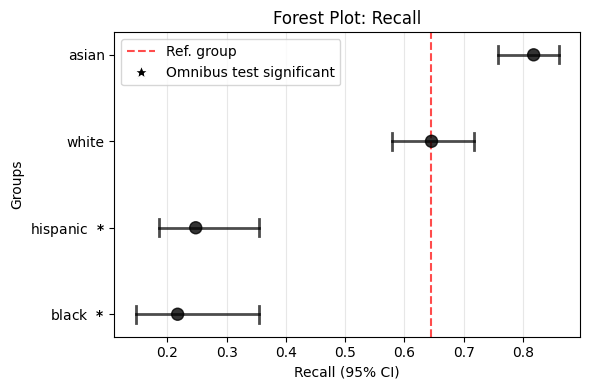

In [28]:
eqb.eq_plot_bootstrap_forest(
    race_metrics,
    metric="Recall",
    reference_group="white",
    title="Forest Plot: Recall",
    statistical_tests=stat_test_results,
)

In [29]:
calculate_bootstrap_stats(group_boot_metrics=race_metrics, metric="Accuracy")

group    mean  ci_lower  ci_upper       std  n_samples
0     white  0.6616     0.628     0.708  0.028800       1000
1  hispanic  0.6000     0.536     0.640  0.028171       1000
2     asian  0.6920     0.656     0.720  0.026107       1000
3     black  0.6428     0.600     0.692  0.025301       1000